In [ ]:
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import pandas as pd
import numpy as np
from ast import literal_eval
import logging
import re
from difflib import SequenceMatcher
from typing import Dict
from typing import Optional
from typing import Union
from urllib import parse as parser
from urllib.request import urlopen
import keras
import time
from datetime import datetime
import glob
import operator
import lightgbm
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import shap
from collections import defaultdict
shap.initjs()


In [5]:
path = r'removed' # use your path
allFiles = glob.glob(path + "*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, header = 0) 
    list_.append(df)

frame = pd.concat(list_)

In [52]:
inputs = frame[["user_id",
                                "event_type",  
                                "timestamp", 
                                "properties.extensionIsOpen",
                                "properties.url", 
                                "properties.sessionID"
                               ]]# dwell time, task time, task_clicks,  task_id, label

In [53]:
inputs = inputs.rename(index=str, columns={"user_id": "distinct_id", 
                              "timestamp": "event_time", 
                              "properties.extensionIsOpen": "panel_out", 
                              "properties.url": "original", 
                              "properties.sessionID": "session_id"})

In [54]:
def normalize_url(url: str):
    result = None
    try:
        parsed = parser.urlparse(url)
    except Exception as e:
        _logger.warning("Error normalizing '%s': %s" % (url, str(e)))
    else:
        protocol = 'http' if parsed.scheme == 'https' else parsed.scheme
        domain = parsed.netloc[4:] if parsed.netloc.lower().startswith('www.') else parsed.netloc
        normal = '%s://%s%s%s' % (protocol, domain, parsed.path, '' if parsed.path.endswith('/') else '/')
        result = {
            'original': url,
            'normal': normal,
            'protocol': parsed.scheme,
            'domain': domain,
            'path': parsed.path,
            'query': dict(parser.parse_qsl(parsed.query)),
            'params': parsed.params,
            'fragment': parsed.fragment,
        }
    finally:
        return result


In [ ]:
pattern = '%Y-%m-%d %H:%M:%S'
inputs.event_time = inputs.event_time.apply(lambda x: int(time.mktime(time.strptime(x, pattern))))
users = dict(zip(inputs.distinct_id.unique(), (i for i in range(len(inputs.distinct_id.unique())))))
inputs["distinct_id"] = inputs["distinct_id"].map(users)
lists = inputs.values.tolist()

In [ ]:
lists = sorted(lists, key=operator.itemgetter(0,2), reverse=False)

In [ ]:
last_activity_time = lists[0][2]
task_id = 1
task_time_start = lists[0][2]
total_durations = []
for idx, lst in enumerate(lists):
    distinct_id, event, timestamp, panel, url, sess = lst
    time_diff = timestamp - last_activity_time
    if np.abs(time_diff) > 900:
        task_id +=1
        task_time_start = timestamp
        total_durations.append(lists[idx-1])
    task_duration = timestamp - task_time_start

    lists[idx].append(task_id)
    lists[idx].append(task_duration)
    last_activity_time = timestamp


In [ ]:
inputs = pd.DataFrame(lists, columns = ["distinct_id", "event_type", "event_time", "panel_out", "original", "session_id", 'task_id', "task_duration"])

In [42]:
inputs.to_csv("data.csv")

In [32]:
inputs = inputs[["event_type", "event_time", "panel_out", "original", 'task_id', "task_duration"]] # dwell time, task time, task_clicks,  task_id, label

In [33]:
set_of_positive_tasks = set(inputs.loc[inputs['event_type'] == "Extension - Clicked Contact Button"]["task_id"])

In [34]:
inputs["label"] = pd.Series.isin(inputs["task_id"], set_of_positive_tasks).astype(int)

In [35]:
inputs["original"] = inputs["original"].fillna("")
inputs["original"] = inputs["original"].apply(lambda x: normalize_url(x)["domain"])

In [36]:
urls = dict(inputs.original.value_counts(0))

In [37]:
filtered_urls = {k:v for (k,v) in urls.items() if v > 1000 and k != ""} 

In [38]:
filtered_urls = set(filtered_urls)

In [39]:
inputs["url"] = pd.Series.isin(inputs["original"], filtered_urls)

In [40]:
inputs["original"] = inputs.loc[inputs['url'] == True]["original"]

In [41]:

inputs["panel_out"] = inputs.panel_out.fillna(False)
inputs.panel_out = inputs.panel_out.astype(int)

event_type_dict = dict(zip(inputs.event_type.unique(), (i for i in range(len(inputs.event_type.unique())))))
inputs.event_type = inputs.event_type.map(event_type_dict)

original_dict = dict(zip(inputs.original.unique(), (i for i in range(len(inputs.original.unique())))))
inputs.original = inputs.original.map(original_dict)


In [44]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940734 entries, 0 to 1940733
Data columns (total 8 columns):
event_type       int64
event_time       int64
panel_out        int64
original         int64
task_id          int64
task_duration    int64
label            int64
url              bool
dtypes: bool(1), int64(7)
memory usage: 105.5 MB


In [45]:
inputs["event_binarized"] = [np.zeros(16) for i in range(len(inputs["event_type"]))]
inputs["url_binarized"] = [np.zeros(len(filtered_urls)) for i in range(len(inputs["original"]))]

In [46]:
inputs = inputs[inputs["event_type"] != 12]

In [ ]:
lists = inputs.values.tolist()

In [ ]:
for i in lists:
    i[8] = np.insert(i[8], i[0], 1)
    i[9] = np.insert(i[9], i[3], 1)


In [ ]:
inputs = pd.DataFrame(lists, columns = ["event_type", "event_time", "panel_out", "original", 'task_id', "task_duration", "label", "url", "event_binarized", "url_binarized"])

In [ ]:
inputs = inputs[['task_id', "task_duration","panel_out", "event_binarized", "url_binarized", "label"]]

In [ ]:
inputs['change'] = inputs['task_id'].diff()

In [ ]:
index_before = 0
lists = []
for i, index_ in enumerate(inputs.loc[inputs['change'] == 1.0].index):
    panel = inputs.loc[index_before:index_][['panel_out']].sum()/(index_ - index_before)
    data = inputs.loc[index_before:index_][['event_binarized', 'url_binarized']].sum()
    label = inputs.loc[index_-1][['label']]
    task_dur = inputs.loc[index_-1][['task_duration']]
    lists.append((data.values, panel.values, task_dur.values, label.values))
    index_before = index_


In [ ]:
df = pd.DataFrame(lists, columns=["binarized", "panel", "task_duration", "label"])

In [36]:
df["concat"] = [np.concatenate((df["binarized"][i][0], df["binarized"][i][1]), axis=0) for i in range(len(df["binarized"]))]

In [37]:
df["binarized"] = [np.concatenate((df["concat"][i], df["panel"][i], df["task_duration"][i])) for i in range(len(df["binarized"]))]

In [38]:
df = df[["binarized", "label"]]

In [39]:
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):int(0.9*(len(df)))]
test = df[int(0.9*(len(df))):]

In [40]:
train_data = np.array(train.binarized.tolist())
train_labels = np.array(train.label.tolist())
train_labels=train_labels.astype('int')

In [42]:
train_data.shape

(3013, 147)

In [43]:
test_data = np.array(test.binarized.tolist())
test_labels = np.array(test.label.tolist())
test_labels=test_labels.astype('int')

In [44]:
logreg = linear_model.LogisticRegression(C=10)

In [45]:
logreg.fit(train_data, train_labels.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
y_pred = logreg.predict(test_data)

In [1]:
metrics.average_precision_score(test_labels, y_pred)
metrics.roc_auc_score(test_labels, y_pred)
metrics.f1_score(test_labels, y_pred)


NameError: name 'metrics' is not defined

In [49]:
gbm = lightgbm.LGBMClassifier(max_depth=5, 
                              n_estimators=128, 
                              learning_rate=0.2, 
                              colsample_bytree = 0.5, 
                              num_leaves = 5).fit(train_data, train_labels.ravel())

features = gbm.feature_importances_
y_gbm_pred = gbm.predict(test_data)

In [ ]:
metrics.average_precision_score(test_labels, y_gbm_pred)
metrics.roc_auc_score(test_labels, y_gbm_pred)
metrics.f1_score(test_labels, y_gbm_pred)

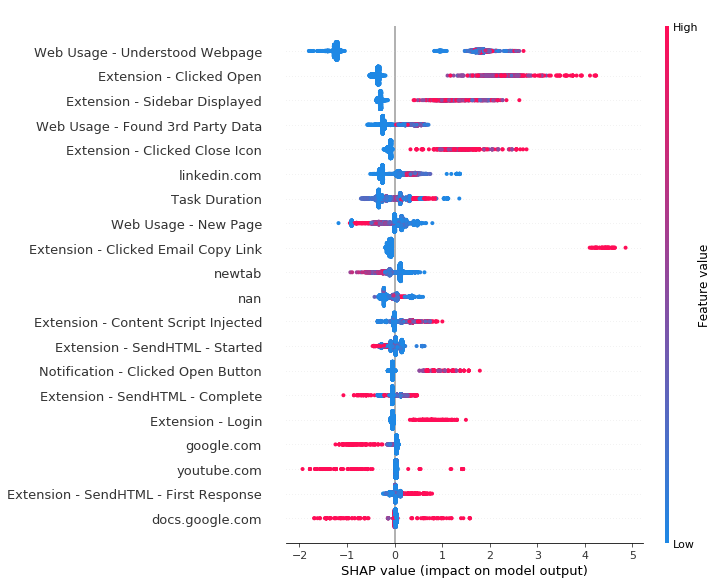

In [56]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(train_data)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, train_data, list(event_type_dict.values()))

